In [20]:
from elasticsearch import Elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from sklearn.linear_model import LinearRegression

In [21]:
es = Elasticsearch(
        'https://127.0.0.1:9200',
        basic_auth=('elastic', 'gHcmDFVtcTaCkB4QPVHSYkEe7bTbYd!x'),
        verify_certs=False
    )

/home/kejing/miniconda3_py38/lib/python3.8/site-packages/elasticsearch/_sync/client/__init__.py:399: SecurityWarning: Connecting to 'https://127.0.0.1:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(


In [22]:
# def secret(key: str) -> str:
#     """Read secret from k8s secret volume"""
#     with open(f"/secrets/default/secrets/{key}", "r", encoding="utf-8") as f:
#         return f.read()


# host = secret("ES_URL")
# basic_auth = (secret("ES_USERNAME"), secret("ES_PASSWORD"))
# es = Elasticsearch(host, basic_auth=basic_auth, verify_certs=False)

In [23]:
# 定义查询语句
query = {
    "query": {
        "match_all": {}
    }
}

# 执行查询
weather_index_name = 'bom_melbourne_weather_past'
response = es.search(index=weather_index_name, body=query, size=500)  # size 参数设置为较大值以获取更多数据
weather_hits = response['hits']['hits']
weather_data = []

for hit in weather_hits:
    source = hit['_source']
    weather_data.append({
        'Date': source['Date'],
        'Rainfall (mm)': source['Rainfall (mm)']
    })

weather_df = pd.DataFrame(weather_data)
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
weather_df = weather_df.sort_values('Date')
weather_df.set_index('Date', inplace=True)

weather_df

# # 转换 Date 列为日期格式
# df['Date'] = pd.to_datetime(df['Date'])

# # 按日期排序
# df = df.sort_values('Date')

# # 设置 Date 列为索引
# df.set_index('Date', inplace=True)

# # 显示前几行数据
# print(df.head())

# # 数据分析和可视化示例
# plt.figure(figsize=(12, 6))
# plt.plot(df.index, df['Rainfall (mm)'], marker='o')
# plt.title('Rainfall Over Time')
# plt.xlabel('Date')
# plt.ylabel('Rainfall (mm)')
# plt.grid(True)
# plt.show()


/tmp/ipykernel_9012/3459406056.py:10: DeprecationWarning: Received 'size' via a specific parameter in the presence of a 'body' parameter, which is deprecated and will be removed in a future version. Instead, use only 'body' or only specific parameters.
  response = es.search(index=weather_index_name, body=query, size=500)  # size 参数设置为较大值以获取更多数据
/home/kejing/miniconda3_py38/lib/python3.8/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host '127.0.0.1'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,Rainfall (mm)
Date,
2023-04-01,4.6
2023-04-02,0.2
2023-04-03,0.0
2023-04-04,0.0
2023-04-05,0.0
...,...
2024-05-09,0.0
2024-05-10,14.0
2024-05-11,1.8


In [26]:
def get_accident_count(date):
    url = f"http://localhost:9090/traffic-accident/accident-count/{date}"
    headers = {"X-Fission-Params-Date": date}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json().get('center_accidents', 0)
    else:
        return 0

# 创建一个 DataFrame 存储事故数量数据
accident_data = []

# 假设日期范围为 2023-04-01 到 2023-04-30
date_range = pd.date_range(start='2023-04-01', end='2023-09-30')

for date in date_range:
    date_str = date.strftime('%Y-%m-%d')
    accident_count = get_accident_count(date_str)
    accident_data.append({
        'Date': date,
        'Accident Count': accident_count
    })

# 创建 DataFrame
accident_df = pd.DataFrame(accident_data)

# 设置 Date 列为索引
accident_df.set_index('Date', inplace=True)

# 显示前几行数据
print(accident_df.head())


            Accident Count
Date                      
2023-04-01              13
2023-04-02              12
2023-04-03              12
2023-04-04              12
2023-04-05               9


            Rainfall (mm)  Accident Count
Date                                     
2023-04-01            4.6              13
2023-04-02            0.2              12
2023-04-03            0.0              12
2023-04-04            0.0              12
2023-04-05            0.0               9


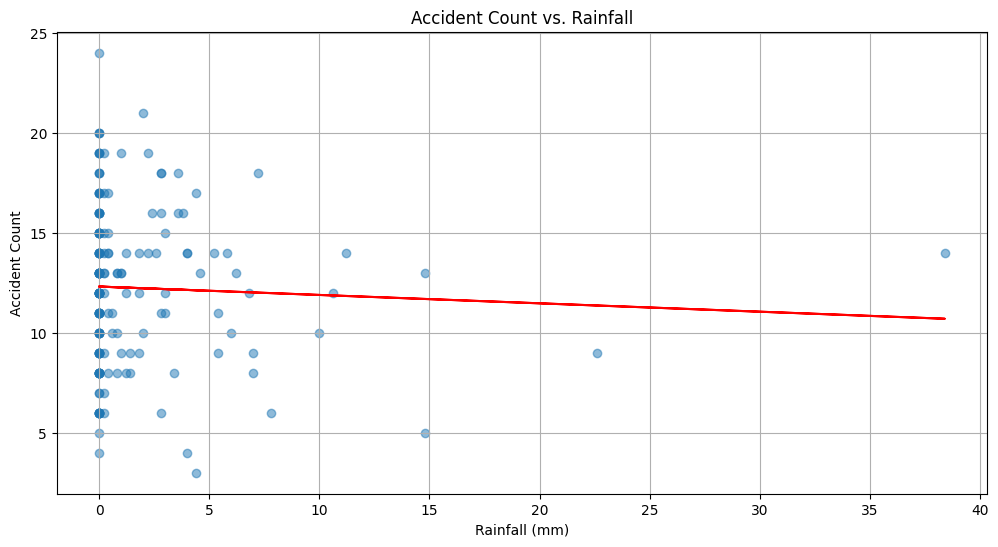

In [27]:
# 合并数据
combined_df = pd.merge(weather_df, accident_df, left_index=True, right_index=True)

# 显示前几行数据
print(combined_df.head())

# scatter plot 
plt.figure(figsize=(12, 6))
# plt.scatter(combined_df['Accident Count'], combined_df['Rainfall (mm)'], alpha=0.5)
plt.scatter(combined_df['Rainfall (mm)'], combined_df['Accident Count'], alpha=0.5)

# X = combined_df['Rainfall (mm)'].values.reshape(-1, 1)  # 自变量
# y = combined_df['Accident Count'].values  # 因变量

# model = LinearRegression()
# model.fit(X, y)
# best_fit_line = model.predict(X)
# plt.plot(combined_df['Rainfall (mm)'], best_fit_line, color='red', label='Best fit line')

plt.title('Accident Count vs. Rainfall')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Accident Count')
plt.grid(True)
plt.show()